=== Entraînement du Transformer classique ===
Epoch 1/10, Loss: 0.4042
Epoch 2/10, Loss: 0.0792
Epoch 3/10, Loss: 0.0479
Epoch 4/10, Loss: 0.0434
Epoch 5/10, Loss: 0.0388
Epoch 6/10, Loss: 0.0363
Epoch 7/10, Loss: 0.0364
Epoch 8/10, Loss: 0.0333
Epoch 9/10, Loss: 0.0329
Epoch 10/10, Loss: 0.0311
Test Loss: 0.0245
=== Entraînement du Transformer avec FAN ===
Epoch 1/10, Loss: 0.4142
Epoch 2/10, Loss: 0.0827
Epoch 3/10, Loss: 0.0521
Epoch 4/10, Loss: 0.0427
Epoch 5/10, Loss: 0.0390
Epoch 6/10, Loss: 0.0364
Epoch 7/10, Loss: 0.0347
Epoch 8/10, Loss: 0.0336
Epoch 9/10, Loss: 0.0323
Epoch 10/10, Loss: 0.0304
Test Loss: 0.0220


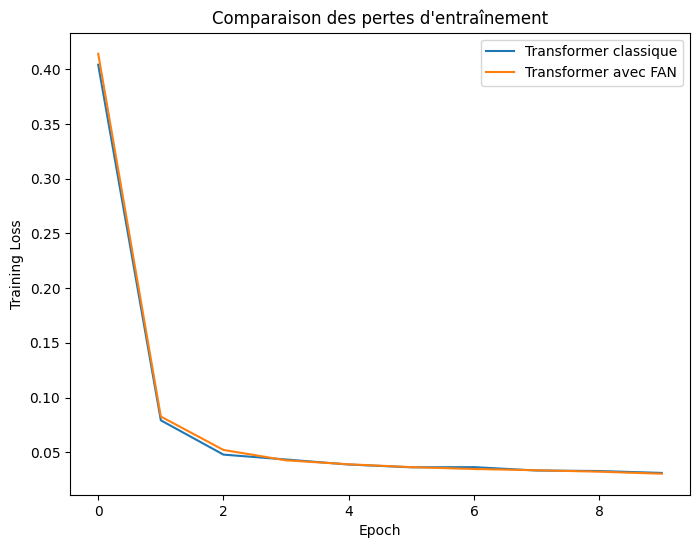

In [2]:
# Transformer_FAN_vs_Classic.ipynb

# In[1]: Import des bibliothèques et des modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from data_loader import load_etth1
from models import TransformerForecast

# In[2]: Définition des fonctions d'entraînement et d'évaluation
def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cpu'):
    model.to(device)
    losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * x.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
        losses.append(epoch_loss)
    return losses

def evaluate_model(model, test_loader, criterion, device='cpu'):
    model.to(device)
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    print(f'Test Loss: {avg_loss:.4f}')
    return avg_loss

# In[3]: Paramètres et chargement des données
seq_len = 96
pred_len = 24
batch_size = 32
num_epochs = 10
learning_rate = 0.001
d_model = 64
nhead = 4
num_layers = 2
d_ff = 128
input_size = 1       # Univarié
output_size = pred_len  # Prédire "pred_len" valeurs

# Assurez-vous que le fichier 'data/ETTh1.csv' est disponible
train_dataset, test_dataset = load_etth1('data/ETTh1.csv', seq_len, pred_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# In[4]: Entraînement du Transformer classique
print("=== Entraînement du Transformer classique ===")
model_classic = TransformerForecast(input_size, d_model, nhead, num_layers, d_ff, output_size, use_fan=False)
optimizer_classic = optim.Adam(model_classic.parameters(), lr=learning_rate)
losses_classic = train_model(model_classic, train_loader, criterion, optimizer_classic, num_epochs, device)
test_loss_classic = evaluate_model(model_classic, test_loader, criterion, device)

# In[5]: Entraînement du Transformer avec FAN
print("=== Entraînement du Transformer avec FAN ===")
model_fan = TransformerForecast(input_size, d_model, nhead, num_layers, d_ff, output_size, use_fan=True, fan_p_ratio=0.25)
optimizer_fan = optim.Adam(model_fan.parameters(), lr=learning_rate)
losses_fan = train_model(model_fan, train_loader, criterion, optimizer_fan, num_epochs, device)
test_loss_fan = evaluate_model(model_fan, test_loader, criterion, device)

# In[6]: Comparaison des courbes de perte
plt.figure(figsize=(8,6))
plt.plot(losses_classic, label='Transformer classique')
plt.plot(losses_fan, label='Transformer avec FAN')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Comparaison des pertes d'entraînement")
plt.legend()
plt.show()
